In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit

from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [3]:
cavity_path = "../data/2021_03_24_received_cavity-spectrometer/cavity-spectrometer/L_B_a_1_post_tune_1_1800gr_100ms_734.00nm_2.00mm.txt"
siv_path = "../data/2021_03_24_received_cavity-spectrometer/siv4/sweeper_bwd_scans_"
siv_files = ["13_41_57.txt", "13_42_43.txt", "13_43_30.txt", "13_45_05.txt", "13_45_54.txt", "13_46_44.txt", "13_47_34.txt", "13_48_22.txt", "13_49_11.txt", "13_50_00.txt"]

# Plot Cavity Data 

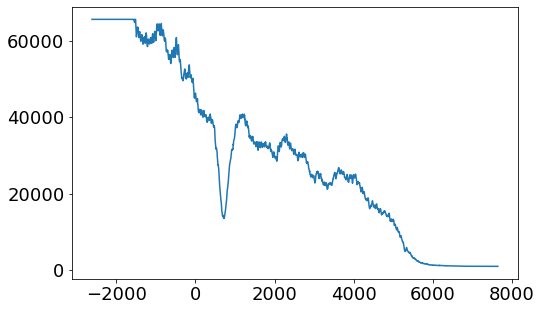

In [4]:
cavity_data = np.loadtxt(cavity_path, skiprows=2, delimiter=",")
lambdas, cavity_counts = cavity_data.T
cavity_freqs = 2.998E8 / lambdas - 406000 # GHz
plt.plot(cavity_freqs, cavity_counts)

## Plot SiV Data

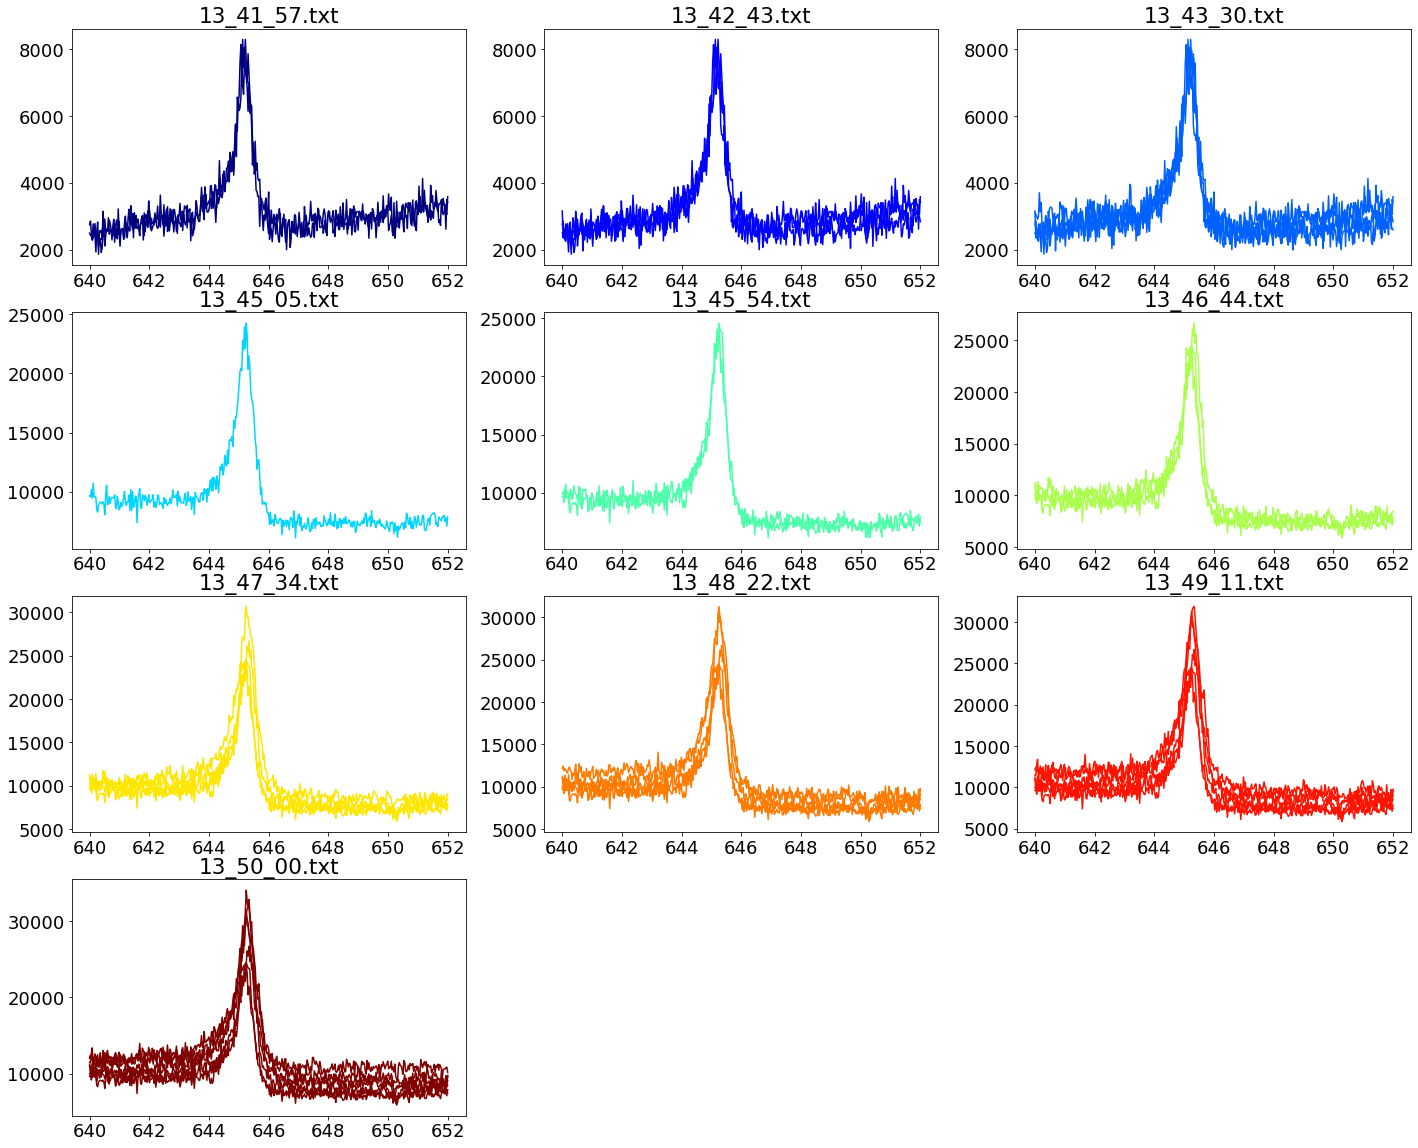

In [29]:
color = plt.cm.jet(np.linspace(0, 1, len(siv_files)))
plt.figure(figsize=[24, 20])

for i, file in enumerate(siv_files):
    siv_data = np.loadtxt(siv_path + file)

    # Convert from (401,) shape to (1, 401)
    if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

    # Extract SiV frequency axis
    siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + file)
    siv_freqs = 1000 * (siv_data_avg[0] - 406)

    plt.subplot(4, 3, i+1)
    plt.gca().title.set_text(file)
    
    for siv_series in siv_data:
        plt.plot(siv_freqs, siv_series, c=color[i])

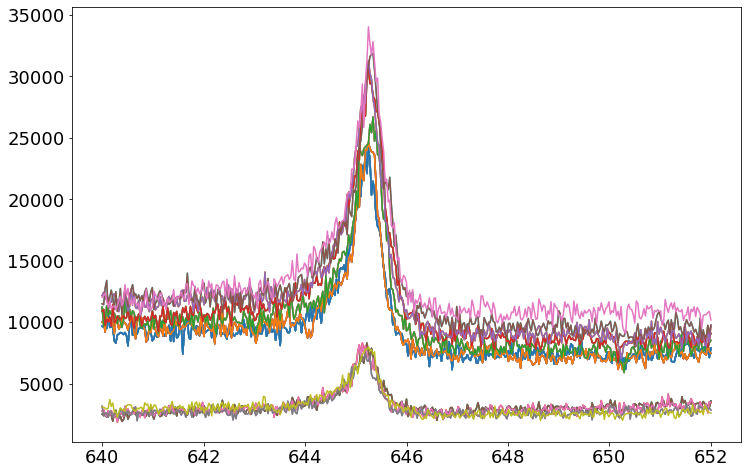

In [30]:
plt.figure(figsize=[12, 8])
for file in siv_files:
    siv_data = np.loadtxt(siv_path + file)
    if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))
    
    # Extract SiV frequency axis
    siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + file)
    siv_freqs = 1000 * (siv_data_avg[0] - 406)
    
    for siv_series in siv_data:
        plt.plot(siv_freqs, siv_series)

# Fit Cavity Spectrum

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 80
    # data points      = 121
    # variables        = 5
    chi-square         = 1.0741e+08
    reduced chi-square = 925939.398
    Akaike info crit   = 1667.26001
    Bayesian info crit = 1681.23896
[[Variables]]
    w_c:    721.859341 +/- 1.03675415 (0.14%) (init = 700)
    k_in:   37.7011050 +/- 9753600.40 (25870860.84%) (init = 100)
    k_tot:  164.092706 +/- 4.54734643 (2.77%) (init = 100)
    A:      43593.5376 +/- 7.9139e+09 (18153868.97%) (init = 40000)
    B:      852.152437 +/- 7.9139e+09 (928698317.17%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, B)        = -1.000
    C(k_in, B)     =  1.000
    C(k_in, A)     = -1.000
    C(k_tot, A)    =  0.131
    C(k_tot, B)    = -0.131
    C(k_in, k_tot) = -0.131


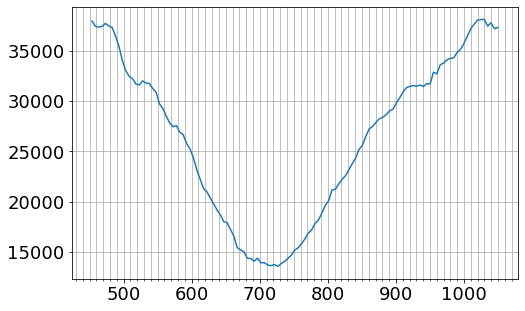

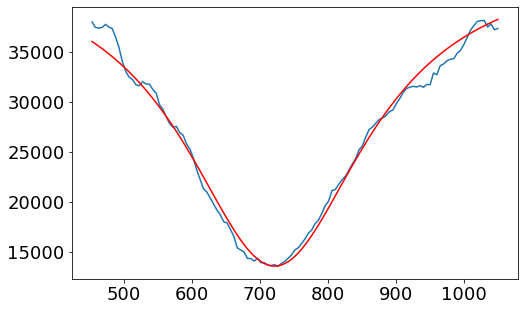

In [153]:
freq_lo = 450
freq_hi = 1050

cavity_freqs_filtered = cavity_freqs[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
cavity_counts_filtered = cavity_counts[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)

plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(5000))
plt.grid(which='both')

##############################

params = Parameters()
params.add_many(
    Parameter('w_c', value=700, min=690, max=730),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=70000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, cavity_freqs_filtered, cavity_counts_filtered, fit_func=fitter.cavity_ref)
lmfit.report_fit(results)

# Compare actual data with fit. Have to add the y-data to the prediction since the function subtracted the y-data 
# in its definition (so that it can try to minimize that function value)
# Alternative: plt.plot(cavity_freqs_filtered, cavity_counts_filtered + results.residual, 'r')
plt.figure()
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)
plt.plot(cavity_freqs_filtered, fitter.cavity_ref(results.params, cavity_freqs_filtered, cavity_counts_filtered) + cavity_counts_filtered, 'r')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 137
    # data points      = 50
    # variables        = 5
    chi-square         = 3657429.03
    reduced chi-square = 81276.2006
    Akaike info crit   = 570.012400
    Bayesian info crit = 579.572515
[[Variables]]
    w_c:    715.953499 +/- 0.43675209 (0.06%) (init = 700)
    k_in:   124.675367 +/- 2221517.43 (1781841.49%) (init = 100)
    k_tot:  159.399874 +/- 9.07243447 (5.69%) (init = 100)
    A:      42641.4685 +/- 1.9682e+09 (4615718.40%) (init = 40000)
    B:      2.5201e-04 +/- 1.9605e+09 (777934518632151.75%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, B)       = -1.000
    C(k_in, A)    =  1.000
    C(k_in, B)    = -1.000
    C(w_c, k_tot) =  0.164


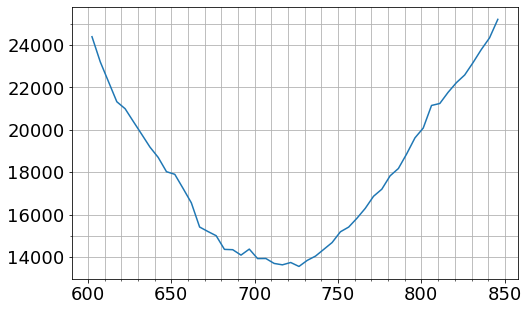

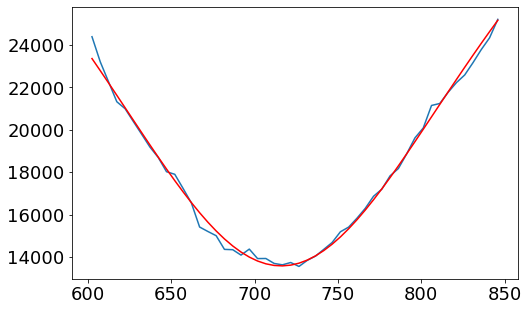

In [151]:
freq_lo = 600
freq_hi = 850

cavity_freqs_filtered = cavity_freqs[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
cavity_counts_filtered = cavity_counts[np.logical_and(freq_lo < cavity_freqs, cavity_freqs < freq_hi)]
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)

plt.gca().xaxis.set_minor_locator(MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(MultipleLocator(5000))
plt.grid(which='both')

##############################

params = Parameters()
params.add_many(
    Parameter('w_c', value=700, min=690, max=730),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=70000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, cavity_freqs_filtered, cavity_counts_filtered, fit_func=fitter.cavity_ref)
lmfit.report_fit(results)

plt.figure()
plt.plot(cavity_freqs_filtered, cavity_counts_filtered)
plt.plot(cavity_freqs_filtered, cavity_counts_filtered + results.residual, 'r')

# Fit SiV Spectrum
## Fitting SiV index 0

2


<ErrorbarContainer object of 3 artists>

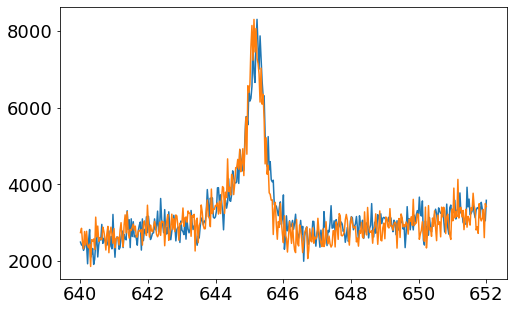

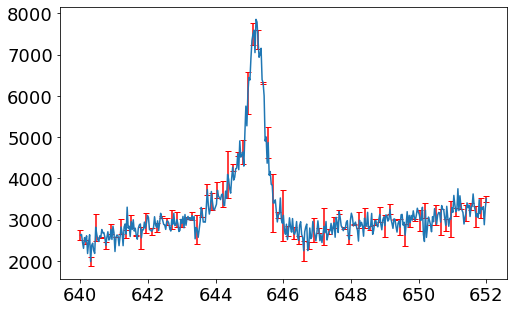

In [154]:
siv_index = 0

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

for i in range(len(siv_data)):
    plt.plot(siv_freqs, siv_data[i])

plt.figure()
siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

### Free fitting

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8127
    # data points      = 401
    # variables        = 8
    chi-square         = 16430241.7
    reduced chi-square = 41807.2307
    Akaike info crit   = 4274.88978
    Bayesian info crit = 4306.84147
[[Variables]]
    w_up:      645.261435 +/- 0.24844322 (0.04%) (init = 645)
    g_up:      2.77187955 +/- 0.34605360 (12.48%) (init = 5.6)
    gamma_up:  0.27476114 +/- 2.21301896 (805.43%) (init = 0.1)
    w_c:       632.475332 +/- 26.0305639 (4.12%) (init = 715)
    k_in:      97.6756025 +/- 7552.57846 (7732.31%) (init = 20)
    k_tot:     224.175086 +/- 14642.7132 (6531.82%) (init = 33)
    A:         141386.990 +/- 17686720.2 (12509.44%) (init = 6000)
    B:         1.4253e-06 +/- 1579.71899 (110835849526.73%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot)     =  1.000
    C(k_in, A)         =  1.000
    C(k_tot, A)        =  1.000
    C(gamma_up, k_tot) =  1.000
  

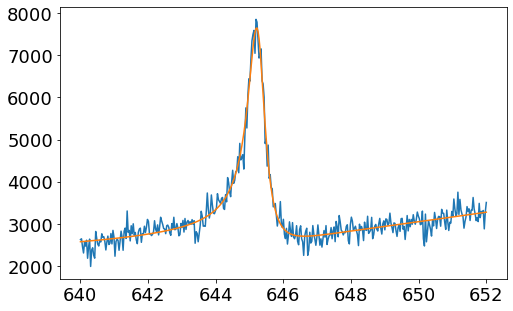

In [142]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=20, min=0, max=100),
    Parameter('k_tot', value=33, min=0, max=250),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

### Fix the total kappa from cavity value

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 329
    # data points      = 401
    # variables        = 7
    chi-square         = 16447589.5
    reduced chi-square = 41745.1511
    Akaike info crit   = 4273.31295
    Bayesian info crit = 4301.27068
[[Variables]]
    w_up:      645.259652 +/- 0.00687568 (0.00%) (init = 645)
    g_up:      2.77680177 +/- 0.07142800 (2.57%) (init = 5.6)
    gamma_up:  0.26114675 +/- 0.00721100 (2.76%) (init = 0.1)
    w_c:       633.591529 +/- 4.76323783 (0.75%) (init = 715)
    k_in:      65.8829293 +/- 10.5812869 (16.06%) (init = 20)
    k_tot:     159.38 (fixed)
    A:         79246.1248 +/- 25590.3264 (32.29%) (init = 6000)
    B:         0.00476033 +/- 3077.85922 (64656381.51%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        =  0.999
    C(w_c, A)         =  0.990
    C(w_c, k_in)      =  0.989
    C(w_c, B)         =  0.984
    C(k_in, A)        =  0.981
    C(A, B)           

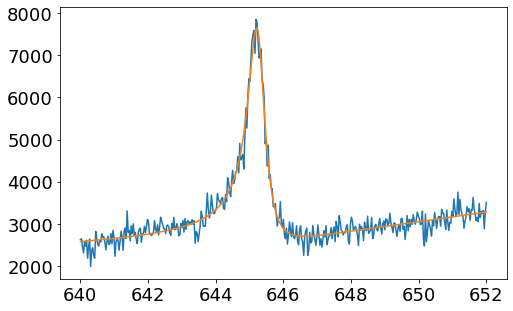

In [141]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=20, min=0, max=100),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 6

4
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2101
    # data points      = 401
    # variables        = 7
    chi-square         = 1.3212e+08
    reduced chi-square = 335332.504
    Akaike info crit   = 5108.81221
    Bayesian info crit = 5136.76994
[[Variables]]
    w_up:      645.285443 +/- 0.02280082 (0.00%) (init = 645)
    g_up:      7.70396162 +/- 0.78528454 (10.19%) (init = 5.6)
    gamma_up:  1.0614e-10 +/- 0.00402722 (3794126760.87%) (init = 0.1)
    w_c:       608.066316 +/- 2.17612877 (0.36%) (init = 715)
    k_in:      37.7267605 +/- 4.59471465 (12.18%) (init = 20)
    k_tot:     159.38 (fixed)
    A:         24137.7600 +/- 4416.89185 (18.30%) (init = 6000)
    B:         1000.00000 +/- 150861.580 (15086.16%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_up, gamma_up) =  0.996
    C(gamma_up, A)    = -0.996
    C(g_up, A)        = -0.990
    C(w_up, g_up)     = -0.980
    C(w_up, gamma_up) = -0.979
    C(w_up, 

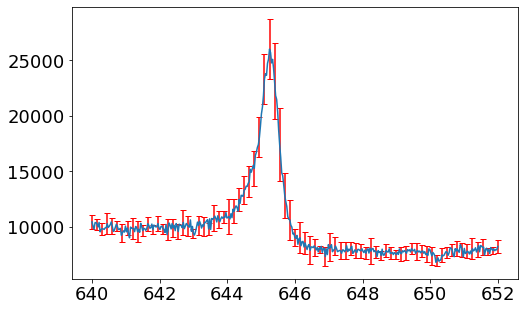

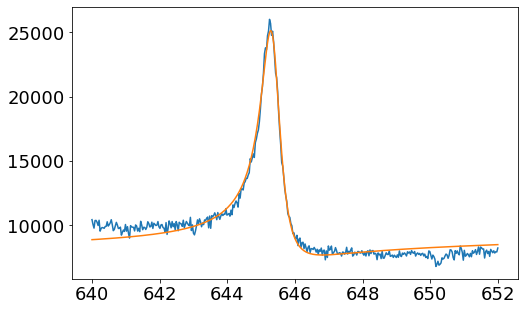

In [147]:
siv_index = 6

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=20, min=0, max=100),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 7

5
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4636
    # data points      = 401
    # variables        = 7
    chi-square         = 1.4724e+08
    reduced chi-square = 373706.303
    Akaike info crit   = 5152.25960
    Bayesian info crit = 5180.21733
[[Variables]]
    w_up:      645.282739 +/- 0.02405606 (0.00%) (init = 645)
    g_up:      7.73624028 +/- 0.80909872 (10.46%) (init = 5.6)
    gamma_up:  2.5991e-10 +/- 0.07929936 (30509937447.48%) (init = 0.1)
    w_c:       607.786440 +/- 2.24425601 (0.37%) (init = 715)
    k_in:      37.6592187 +/- 285.827165 (758.98%) (init = 20)
    k_tot:     159.38 (fixed)
    A:         24930.7889 +/- 131525.500 (527.56%) (init = 6000)
    B:         1000.00000 +/- 238902.478 (23890.25%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        =  1.000
    C(A, B)           = -0.999
    C(k_in, A)        = -0.999
    C(g_up, gamma_up) =  0.996
    C(w_up, gamma_up) = -0.979
    C(w_u

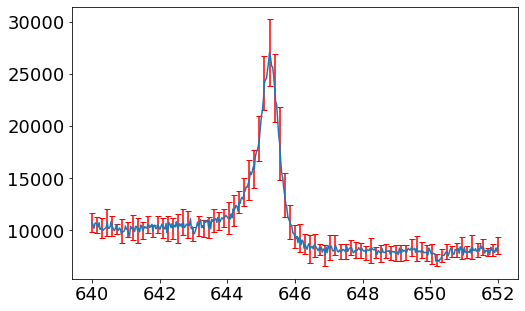

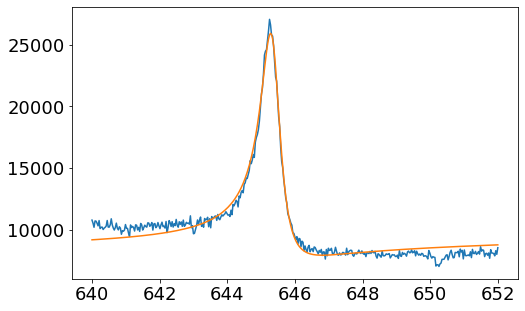

In [146]:
siv_index = 7

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)     
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=20, min=0, max=100),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 8

6
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2663
    # data points      = 401
    # variables        = 7
    chi-square         = 1.5102e+08
    reduced chi-square = 383310.499
    Akaike info crit   = 5162.43504
    Bayesian info crit = 5190.39277
[[Variables]]
    w_up:      645.290930 +/- 0.02364007 (0.00%) (init = 645)
    g_up:      7.77156018 +/- 0.82344234 (10.60%) (init = 5.6)
    gamma_up:  4.7907e-09 +/- 0.54738882 (11426058426.24%) (init = 0.1)
    w_c:       608.811498 +/- 2.17517785 (0.36%) (init = 715)
    k_in:      37.2703297 +/- 4.69182851 (12.59%) (init = 20)
    k_tot:     159.38 (fixed)
    A:         25538.3502 +/- 4804.00224 (18.81%) (init = 6000)
    B:         1000.00000 +/- 144530.124 (14453.01%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma_up, A)    = -0.996
    C(g_up, gamma_up) =  0.996
    C(g_up, A)        = -0.993
    C(w_up, g_up)     = -0.980
    C(w_up, gamma_up) = -0.979
    C(w_up,

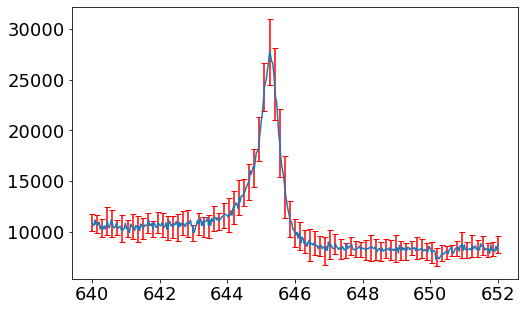

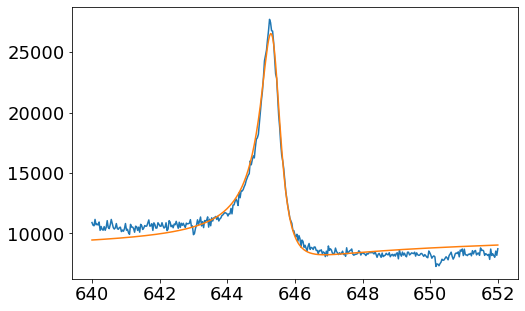

In [145]:
siv_index = 8

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)     
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=20, min=0, max=100),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 1

3
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 769
    # data points      = 401
    # variables        = 7
    chi-square         = 10033479.0
    reduced chi-square = 25465.6827
    Akaike info crit   = 4075.11809
    Bayesian info crit = 4103.07582
[[Variables]]
    w_up:      645.246659 +/- 0.00549934 (0.00%) (init = 645)
    g_up:      3.00542717 +/- 0.06931692 (2.31%) (init = 5.6)
    gamma_up:  0.25473201 +/- 0.00600677 (2.36%) (init = 0.1)
    w_c:       633.408097 +/- 4.61541695 (0.73%) (init = 715)
    k_in:      66.5104037 +/- 10.6090053 (15.95%) (init = 20)
    k_tot:     159.38 (fixed)
    A:         64679.8054 +/- 19926.0272 (30.81%) (init = 6000)
    B:         616.541273 +/- 2463.93734 (399.64%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        =  0.999
    C(w_c, k_in)      =  0.992
    C(w_c, A)         =  0.990
    C(w_c, B)         =  0.989
    C(k_in, A)        =  0.983
    C(A, B)           =  

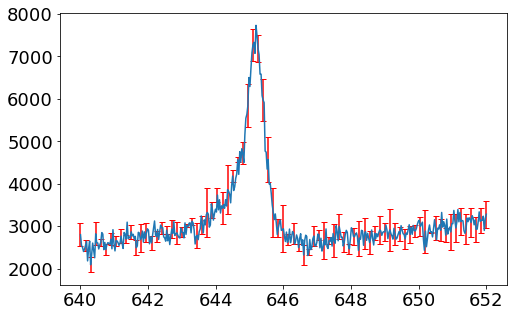

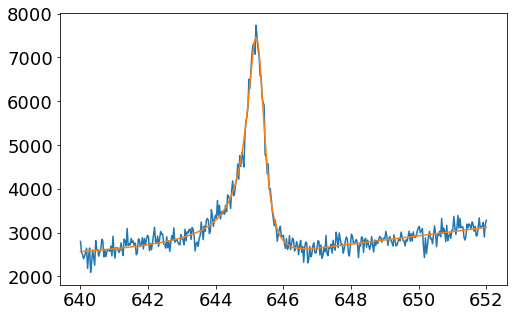

In [155]:
siv_index = 1

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)     
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=20, min=0, max=100),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)

## Fitting SiV index 2

4
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 505
    # data points      = 401
    # variables        = 7
    chi-square         = 8302962.47
    reduced chi-square = 21073.5088
    Akaike info crit   = 3999.20276
    Bayesian info crit = 4027.16049
[[Variables]]
    w_up:      645.257762 +/- 0.00658839 (0.00%) (init = 645)
    g_up:      3.66428578 +/- 0.10143380 (2.77%) (init = 5.6)
    gamma_up:  0.22593740 +/- 0.00692336 (3.06%) (init = 0.1)
    w_c:       627.461424 +/- 12.2553685 (1.95%) (init = 715)
    k_in:      58.5383572 +/- 35.2556414 (60.23%) (init = 20)
    k_tot:     159.38 (fixed)
    A:         33474.9112 +/- 12398.2855 (37.04%) (init = 6000)
    B:         5.0236e-04 +/- 150491.618 (29957130574.72%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, B)        =  1.000
    C(w_c, k_in)      =  0.998
    C(w_c, B)         =  0.998
    C(w_c, A)         =  0.988
    C(k_in, A)        =  0.985
    C(A, B)      

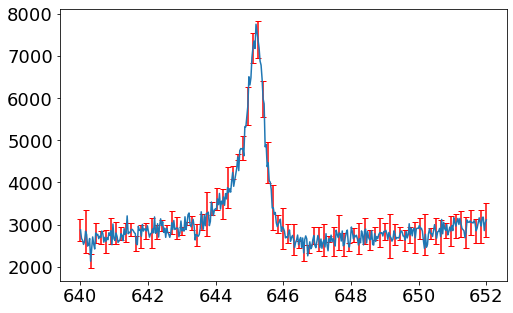

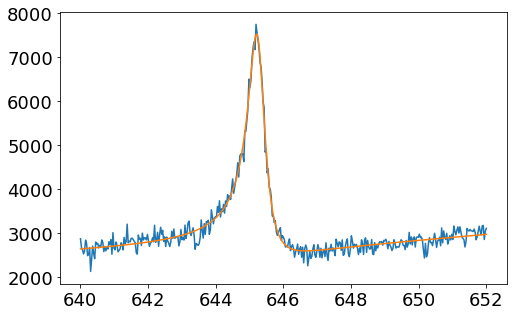

In [156]:
siv_index = 2

siv_data = np.loadtxt(siv_path + siv_files[siv_index])
if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))

# Extract SiV frequency axis
siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + siv_files[siv_index])
siv_freqs = 1000 * (siv_data_avg[0] - 406)

print(len(siv_data))

siv_mean = np.sum(siv_data, axis=0)/len(siv_data)
siV_error = np.std(siv_data, axis=0)     
plt.errorbar(siv_freqs, siv_mean, yerr=siV_error, errorevery=5, ecolor="r", capsize=3)

plt.figure()
params = Parameters()
params.add_many(
    Parameter('w_up', value=645, min=644, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=20, min=0, max=100),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0.1, min=0, max=1000),
)

results = fitter.fit_reflection(params, siv_freqs, siv_mean, fit_func=fitter.single_siv_ref)
lmfit.report_fit(results)

plt.plot(siv_freqs, siv_mean)
plt.plot(siv_freqs, siv_mean + results.residual)